In [562]:
# !pip install mglearn
# !pip install guidedlda

    100% |████████████████████████████████| 2.1MB 10.2MB/s ta 0:00:01
  Running setup.py bdist_wheel for guidedlda ... done
  Stored in directory: /Users/kellyjones/Library/Caches/pip/wheels/cf/cb/c4/95897cbe4e2e12bd01db3c5cb004c744d2cfd68ecc692ce39e
Successfully built guidedlda


In [459]:
import pandas as pd
import numpy as np
import os
import glob
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
from textblob import TextBlob
from collections import Counter
from operator import itemgetter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import gensim
import collections
import smart_open
import random
import mglearn
import guidedlda
%matplotlib inline

# Preprocessing

## Create DataFrame

In [460]:
df = pd.read_csv('data/data_lettersfromgrandma.csv', index_col=False)
df

,letter_id,input_id,letter_date,year,transcribed,transcribed_by,needs_formatting,sender,sender_loc,sender_loc_raw,...,envelope,partial,postcard,postage,words,message_full,message_salutation,message_body,message_closing,url
0,1,1116,11/17/41,1941,1,Kelly Jones,0.0,Elizabeth Jones,unknown,unknown,...,1.0,0.0,0,NaN,306.0,"Dear Mom, Pop, ""etc"" (that means you too Franc...","Dear Mom, Pop, ""etc"" (that means you too Franc...",Miss O Ryan says I may come home Wednesday and...,"Love, Lizzie.",https://static1.squarespace.com/static/5ad67c3...
1,2,1117,12/5/45,1945,1,Kelly Jones,0.0,Elizabeth Jones,"Riverside, CA","Riverside, CA",...,1.0,0.0,0,0.08,2081.0,Dearest Mom and Daddy. Your letter came about ...,Dearest Mom and Daddy.,"Your letter came about an hour ago, Mom. The t...","All my love, Betty.",https://static1.squarespace.com/static/5ad67c3...
2,3,1121,9/26/46,1946,1,Kelly Jones,0.0,Elizabeth Jones,"Riverside, CA","Riverside, CA",...,1.0,0.0,0,0.09,796.0,"Dearest Mom, Pop, and Kidlets. Mom your super-...","Dearest Mom, Pop, and Kidlets.","Mom your super-duper letters came, so will ans...","Once again, I must scoot to bed, soooo once ag...",https://static1.squarespace.com/static/5ad67c3...
3,4,1120,10/6/46,1946,1,Kelly Jones,0.0,Elizabeth Jones,"Yoleta, TX","Yoleta, TX",...,1.0,0.0,0,0.03,863.0,"Dearest Mom, Pop, and kidlets. My little man i...","Dearest Mom, Pop, and kidlets.","My little man is writing to his folks, so I'll...","Lots of love from us both, Betty and Mutt.",https://static1.squarespace.com/static/5ad67c3...
4,5,1119,10/8/46,1946,1,Kelly Jones,0.0,Elizabeth Jones,"El Paso, TX","El Paso, TX",...,1.0,0.0,0,0.06,627.0,Dearest Folks. We got your super-duper letter ...,Dearest Folks.,"We got your super-duper letter yesterday, Mom,...","Lots of love, Betty and Mutt.",https://static1.squarespace.com/static/5ad67c3...
5,6,1118,10/21/46,1946,1,Kelly Jones,0.0,Elizabeth Jones,"El Paso, TX","El Paso, TX",...,1.0,0.0,0,0.02,1837.0,"Dearest Mom, Pop, and Kidlets. I'm lying on my...","Dearest Mom, Pop, and Kidlets.","I'm lying on my tummy on the bed, so if you ca...","Love, Betty.",https://static1.squarespace.com/static/5ad67c3...
6,7,1122,1/25/47,1947,1,Kelly Jones,0.0,Elizabeth Jones,"Sumter, SC","Sumter, SC",...,1.0,0.0,0,0.05,1233.0,"Dear Fritzie. Mutt just brought your ""manuscri...",Dear Fritzie.,"Mutt just brought your ""manuscript"" home, and ...","Till next time, love from us both, Betty and M...",https://static1.squarespace.com/static/5ad67c3...
7,8,1123,9/6/47,1947,1,Kelly Jones,0.0,Elizabeth Jones,"Sumter, SC","Sumter, SC",...,1.0,0.0,0,0.05,1214.0,"Dearest Mom, Pop, and family. I really hit the...","Dearest Mom, Pop, and family.",I really hit the jackpot yesterday!! Got a let...,"Till next time, all our love, Betty, Mutt, and...",https://static1.squarespace.com/static/5ad67c3...
8,9,1124,9/29/47,1947,1,Kelly Jones,0.0,Elizabeth Jones,"Sumter, SC","Fort Jackson, SC",...,1.0,0.0,0,0.05,529.0,"Dear Grandma, Granddad, Auntie, and Uncles. We...","Dear Grandma, Granddad, Auntie, and Uncles.","Well, we dood it!!! Got the cutest little dark...","Love to all of you from the three of us, Butty...",https://static1.squarespace.com/static/5ad67c3...
9,10,1125,1/5/48,1948,1,Kelly Jones,0.0,Elizabeth Jones,"Shaw Field, SC","Shaw Field, SC",...,1.0,0.0,0,0.05,953.0,Dearest Folks. This is going to be a joint let...,Dearest Folks.,This is going to be a joint letter because I'd...,"Love from your ""rebels"", the South Carolina Jo...",https://static1.squarespace.com/static/5ad67c3...


In [461]:
df.shape

(365, 26)

In [462]:
# one df for all letters (df_all), another for just transcribed (df) where 'transcribed' == 1
df_all = df.copy()


df.dropna(subset=['message_full'], inplace=True)

In [463]:
df_all.shape # should have ~360 rows and 20-30 columns

(365, 26)

In [464]:
df.shape

(176, 26)

In [465]:
df.postcard.sum() # need to drop 5 postcards

5

In [466]:
df = df[df.postcard != 1] # drop 5 postcards
df.shape

(171, 26)

In [467]:
df = df.reset_index(drop=True)
df

,letter_id,input_id,letter_date,year,transcribed,transcribed_by,needs_formatting,sender,sender_loc,sender_loc_raw,...,envelope,partial,postcard,postage,words,message_full,message_salutation,message_body,message_closing,url
0,1,1116,11/17/41,1941,1,Kelly Jones,0.0,Elizabeth Jones,unknown,unknown,...,1.0,0.0,0,NaN,306.0,"Dear Mom, Pop, ""etc"" (that means you too Franc...","Dear Mom, Pop, ""etc"" (that means you too Franc...",Miss O Ryan says I may come home Wednesday and...,"Love, Lizzie.",https://static1.squarespace.com/static/5ad67c3...
1,2,1117,12/5/45,1945,1,Kelly Jones,0.0,Elizabeth Jones,"Riverside, CA","Riverside, CA",...,1.0,0.0,0,0.08,2081.0,Dearest Mom and Daddy. Your letter came about ...,Dearest Mom and Daddy.,"Your letter came about an hour ago, Mom. The t...","All my love, Betty.",https://static1.squarespace.com/static/5ad67c3...
2,3,1121,9/26/46,1946,1,Kelly Jones,0.0,Elizabeth Jones,"Riverside, CA","Riverside, CA",...,1.0,0.0,0,0.09,796.0,"Dearest Mom, Pop, and Kidlets. Mom your super-...","Dearest Mom, Pop, and Kidlets.","Mom your super-duper letters came, so will ans...","Once again, I must scoot to bed, soooo once ag...",https://static1.squarespace.com/static/5ad67c3...
3,4,1120,10/6/46,1946,1,Kelly Jones,0.0,Elizabeth Jones,"Yoleta, TX","Yoleta, TX",...,1.0,0.0,0,0.03,863.0,"Dearest Mom, Pop, and kidlets. My little man i...","Dearest Mom, Pop, and kidlets.","My little man is writing to his folks, so I'll...","Lots of love from us both, Betty and Mutt.",https://static1.squarespace.com/static/5ad67c3...
4,5,1119,10/8/46,1946,1,Kelly Jones,0.0,Elizabeth Jones,"El Paso, TX","El Paso, TX",...,1.0,0.0,0,0.06,627.0,Dearest Folks. We got your super-duper letter ...,Dearest Folks.,"We got your super-duper letter yesterday, Mom,...","Lots of love, Betty and Mutt.",https://static1.squarespace.com/static/5ad67c3...
5,6,1118,10/21/46,1946,1,Kelly Jones,0.0,Elizabeth Jones,"El Paso, TX","El Paso, TX",...,1.0,0.0,0,0.02,1837.0,"Dearest Mom, Pop, and Kidlets. I'm lying on my...","Dearest Mom, Pop, and Kidlets.","I'm lying on my tummy on the bed, so if you ca...","Love, Betty.",https://static1.squarespace.com/static/5ad67c3...
6,7,1122,1/25/47,1947,1,Kelly Jones,0.0,Elizabeth Jones,"Sumter, SC","Sumter, SC",...,1.0,0.0,0,0.05,1233.0,"Dear Fritzie. Mutt just brought your ""manuscri...",Dear Fritzie.,"Mutt just brought your ""manuscript"" home, and ...","Till next time, love from us both, Betty and M...",https://static1.squarespace.com/static/5ad67c3...
7,8,1123,9/6/47,1947,1,Kelly Jones,0.0,Elizabeth Jones,"Sumter, SC","Sumter, SC",...,1.0,0.0,0,0.05,1214.0,"Dearest Mom, Pop, and family. I really hit the...","Dearest Mom, Pop, and family.",I really hit the jackpot yesterday!! Got a let...,"Till next time, all our love, Betty, Mutt, and...",https://static1.squarespace.com/static/5ad67c3...
8,9,1124,9/29/47,1947,1,Kelly Jones,0.0,Elizabeth Jones,"Sumter, SC","Fort Jackson, SC",...,1.0,0.0,0,0.05,529.0,"Dear Grandma, Granddad, Auntie, and Uncles. We...","Dear Grandma, Granddad, Auntie, and Uncles.","Well, we dood it!!! Got the cutest little dark...","Love to all of you from the three of us, Butty...",https://static1.squarespace.com/static/5ad67c3...
9,10,1125,1/5/48,1948,1,Kelly Jones,0.0,Elizabeth Jones,"Shaw Field, SC","Shaw Field, SC",...,1.0,0.0,0,0.05,953.0,Dearest Folks. This is going to be a joint let...,Dearest Folks.,This is going to be a joint letter because I'd...,"Love from your ""rebels"", the South Carolina Jo...",https://static1.squarespace.com/static/5ad67c3...


In [468]:
df.shape # should have ~170 rows as of 6/18/18 for 170ish transcribed letters

(171, 26)

In [469]:
df.message_body.str.lower().to_frame().head()

,message_body
0,miss o ryan says i may come home wednesday and...
1,"your letter came about an hour ago, mom. the t..."
2,"mom your super-duper letters came, so will ans..."
3,"my little man is writing to his folks, so i'll..."
4,"we got your super-duper letter yesterday, mom,..."


In [470]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171 entries, 0 to 170
Data columns (total 26 columns):
letter_id             171 non-null int64
input_id              171 non-null int64
letter_date           171 non-null object
year                  171 non-null int64
transcribed           171 non-null int64
transcribed_by        171 non-null object
needs_formatting      171 non-null float64
sender                171 non-null object
sender_loc            171 non-null object
sender_loc_raw        171 non-null object
sender_latitude       168 non-null float64
sender_longitude      168 non-null float64
recipient             171 non-null object
recipient_loc         171 non-null object
rec_latitude          169 non-null float64
rec_longitude         169 non-null float64
envelope              158 non-null float64
partial               170 non-null float64
postcard              171 non-null int64
postage               107 non-null float64
words                 171 non-null float64
message_f

## Clean Text

In [471]:
def clean_column(colname):
    df[colname] = df[colname].str.replace(
        '’',"'").str.replace(
        '‘',"'").str.replace(
        '“','"').str.replace(
        '”','"').str.replace(
        '&', 'and').str.replace(
        'N Dak', 'North Dakota').str.replace(
        'Albuq.', 'Albuquerque').str.replace(
        'to-day','today').str.replace(
        'to-morrow','tomorrow').str.replace(
        'to-nite','tonight').str.replace(
        "s'pose",'suppose').str.replace(
        "S'pose", 'Suppose').str.replace(
        'Lt Col', 'Lieutenant Colonel').str.replace(
        'AFB', 'Air Force Base').str.replace(
        'xmas', 'Christmas').str.replace(
        'Xmas', 'Christmas')

clean_column('message_full')
clean_column('message_salutation')
clean_column('message_body')
clean_column('message_closing')

In [472]:
print(df['message_full'][40]) # checking message cleaning

Greetings!!  I've got stuff that should be done, but feel like writing to you instead, so here goes!! First of all, for goodness sake don't worry about Richard's arm! It hasn't bothered him at all since a few minutes after he hurt it. The antics these kids go through every day would sure show up anything that might bother them, and he never favors it, so there's nothing wrong with it. The kids next door have a gymnasium set in the yard and the kids hold onto the bar and swing their feet, so if there were anything wrong with his arm that would surely bother him and it doesn't, so he's 100% O.K. Karen smashed her left hand in the car door Sunday night and thought she may have broken a bone in the back of her hand because it swelled up so fast, but she has good use of it. Her hand is still a little swollen and the back of  her hand and fingers are all purple, but it doesn't seem to bother her a bit. Funny how kids can get banged up and never seems to bother them. We're all waiting to hear

## Set Stop Words

In [473]:
stop = stopwords.words('english')
stop += ['.', ',', '(', ')', "'", '"']
stop = set(stop)

# Exploratory NLP

## Sentence Tokenization

In [474]:
# from nltk.tokenize import sent_tokenize

text = df.message_body.astype(str).tolist()
sentences_list = [sent_tokenize(msg) for msg in text]
sentences_list

# original method: worked for single string, had to modify for list
# sentences = sent_tokenize(text_list)
# print(sentences)

[['Miss O Ryan says I may come home Wednesday and do not need to come back to work till Friday noon.',
  "Pretty good, don't you think so?",
  "Haven't seen Helen today, but Mrs Selland said that fam and Helen were in town 'cuz she saw you.",
  "Haven't had any mail except a letter from the corporal and one from the sailor last week.",
  "Suppose Helen won't be through until 6.",
  'I think that maybe I can get through by then, too.',
  'Got all my test papers back now.',
  "I told you some of the marks before, I think, but in case you'd like to know them all here goes: 91 Anatomy (3 kids flunked (below 65) and only 2 others above 90), 98 Ethics, 98 Nursing Arts, 100 Medical Nursing.",
  'Thelma Selling had her appendix removed this morning.',
  'She is feeling pretty good.',
  'Course she has quite a bit of pain yet.',
  '"Mama Gene" came out of her operation fine.',
  "She has a lot of pain though, but that's expected.",
  "They're both grand patients.",
  'Mrs Joe Bakn is also okay.

## TextBlob Sentiment

In [475]:
# from textblob import TextBlob

In [476]:
# test sentiment on diff letters
for msg in df.message_body.tolist():
    print(msg)
    print()
    print(TextBlob(msg).sentiment)
    print()
    print()

Miss O Ryan says I may come home Wednesday and do not need to come back to work till Friday noon. Pretty good, don't you think so? Haven't seen Helen today, but Mrs Selland said that fam and Helen were in town 'cuz she saw you. Haven't had any mail except a letter from the corporal and one from the sailor last week. Suppose Helen won't be through until 6. I think that maybe I can get through by then, too. Got all my test papers back now. I told you some of the marks before, I think, but in case you'd like to know them all here goes: 91 Anatomy (3 kids flunked (below 65) and only 2 others above 90), 98 Ethics, 98 Nursing Arts, 100 Medical Nursing. Thelma Selling had her appendix removed this morning. She is feeling pretty good. Course she has quite a bit of pain yet. "Mama Gene" came out of her operation fine. She has a lot of pain though, but that's expected. They're both grand patients. Mrs Joe Bakn is also okay. Mrs Robert Peterson from Knox has a baby girl and she named it "Betty Lo

Sentiment(polarity=0.030102493587082627, subjectivity=0.49185586103394324)


Praise the Lord and pass the ammunition, you did it again!! Only bad thing about getting a letter from you is that we cannot look for another one for another year! Thanks a million, though. I know your "busy with bossies" so appreciate your letters when we do get them. Also want to thank you for offering us a place to live if Mutt goes overseas, as we have talked about what I would do and frankly, I was stumped, so it is a big relief to know there are four walls and a roof over it that we can move into. Think it is just a matter of time till he will be sent over. Things sure look bad over there now and we do not have the manpower here to take many beatings like the 8th army is taking in Korea. We have wondered so much just where the 606th a.c. and West squadron is over there. That is the squadron we were in in South Carolina and they went over to Korea early last summer. We know a good share of them and then t

Sentiment(polarity=0.06762949335934534, subjectivity=0.46496449456975775)


All is noisier than the very dickens (I'm in the machine shop now) and nothing to do so will send you the latest from the Jones house. Mutt called Saturday night from Cayucos. He and Dad Jones and Dad Stamper were fishing and of course Mutt hadn't caught even a fish yet! They were going to Porterville Sunday and Mutt said he'd call once again if he got a chance before he shipped out. He's supposed to sail on Sunday (Margie's birthday) so I'm expecting a call Saturday. Took Margie downtown this morning and she got her hair cut and does she look like the cute little bug!! She just talked to me on the phone and one of the neighbor ladies just sent word over for her to come over for coffee cuz she'd just made fresh cupcakes, soooo Margie and the kids were going over to "Dottie Viningo." She's a lovely person. Same age as I am, has four girls (one in Karen's class) , her husband works evenings, she takes Margie to c

Just finished the supper and breakfast dishes, so will write a few lines while Johnnie Burns and Doug are up at the table playing with clay. Better I stay close at hand and supervise, anyway, so they don't try to eat it. How did your Blood Sugar report come out, Mom? Thnak you so much for letting us know about Grandpa Jelleberg. Needless to say, we sure were shocked! I got a letter off to Sadie and Everett right away. This has been a busy week. Mutt works different hours every day, so it's a rat race trying to figure out which day we have a big meal at noon and which day we have it at supper time! He doesn't know two days ahead, what hours he will be working. Monday, it was 4P.M. to midnight, Tuesday it was 10 A.M. to 6 P.M., today it was 7:30A.M. -5:30P.M. and tomorrow, he works 4P.m. to midnight, but doesn't know yet what he will work on Friday. Really gets confusing. Monday morning I had the three little Swangler boys here while they went to George's uncle's funeral. Fay got back ab


Well, is it a good day, Mom? Looks real purdy out this way! Boys (twins) are across the street cleaning Major Ormerod's quarters, Mark is still sawing logs, Doug is working at his paperwork for his accordion lesson, Mutt is long gone to work, and I have the washer going, and dishes soaking. We've had a little excitement here. Kept smelling gas outside our bedroom window and Mutt called it in and by golly there was a gas leak alright! They dug down and found a hole bigger than the size of a dime in the elbow of the pipe and then found the pipe cracked about 3 feet farther, so replaced that, and this morning there are more bubbles coming, so guess they'll have to dig up more of Mutt's pretty lawn. Had to shut off the gas on 42 quarters all day Saturday and then they found another leak down the street around the other corner from us and Colonel Ellington said it looked like they were going to have to replace the whole gas line. None of the gas lines that they've uncovered have had any in

Sentiment(polarity=0.15108896146842574, subjectivity=0.47468090771662197)




In [477]:
sentmtlist = [TextBlob(msg).sentiment for msg in df.message_body.tolist()]

In [478]:
len(sentmtlist)

171

In [479]:
sentmtlist

[Sentiment(polarity=0.23641927083333333, subjectivity=0.5102083333333334),
 Sentiment(polarity=0.24265562286775033, subjectivity=0.5078614909740737),
 Sentiment(polarity=0.09647114706737335, subjectivity=0.3919649943310657),
 Sentiment(polarity=0.1905641310196395, subjectivity=0.4339682539682541),
 Sentiment(polarity=0.17201665521978024, subjectivity=0.4693959223646724),
 Sentiment(polarity=0.12517263215179875, subjectivity=0.475836385836386),
 Sentiment(polarity=0.20200136707544453, subjectivity=0.5058210938994071),
 Sentiment(polarity=0.19483392287649884, subjectivity=0.45640571083505876),
 Sentiment(polarity=0.11614266103728313, subjectivity=0.5615540789959395),
 Sentiment(polarity=0.25563768461930225, subjectivity=0.513883116883117),
 Sentiment(polarity=0.25494791666666666, subjectivity=0.4814484126984127),
 Sentiment(polarity=0.15459674873737372, subjectivity=0.5588383838383838),
 Sentiment(polarity=0.021672786125911118, subjectivity=0.39697802197802196),
 Sentiment(polarity=0.161

In [480]:
df_sentmt = pd.DataFrame(sentmtlist)
df_sentmt.head()

,polarity,subjectivity
0,0.236419,0.510208
1,0.242656,0.507861
2,0.096471,0.391965
3,0.190564,0.433968
4,0.172017,0.469396


In [481]:
df_sentmt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171 entries, 0 to 170
Data columns (total 2 columns):
polarity        171 non-null float64
subjectivity    171 non-null float64
dtypes: float64(2)
memory usage: 2.8 KB


In [482]:
df_sentmt.describe()

,polarity,subjectivity
count,171.000000,171.000000
mean,0.135006,0.480115
std,0.064536,0.052043
min,-0.051167,0.350899
25%,0.095035,0.448583
50%,0.136114,0.480414
75%,0.184155,0.514513
max,0.268641,0.630519


In [483]:
df_sentmt.index = df.index # synchronize indices so they concatenate nicely, since order is same
df = pd.concat([df, df_sentmt], axis=1)

df

,letter_id,input_id,letter_date,year,transcribed,transcribed_by,needs_formatting,sender,sender_loc,sender_loc_raw,...,postcard,postage,words,message_full,message_salutation,message_body,message_closing,url,polarity,subjectivity
0,1,1116,11/17/41,1941,1,Kelly Jones,0.0,Elizabeth Jones,unknown,unknown,...,0,NaN,306.0,"Dear Mom, Pop, ""etc"" (that means you too Franc...","Dear Mom, Pop, ""etc"" (that means you too Franc...",Miss O Ryan says I may come home Wednesday and...,"Love, Lizzie.",https://static1.squarespace.com/static/5ad67c3...,0.236419,0.510208
1,2,1117,12/5/45,1945,1,Kelly Jones,0.0,Elizabeth Jones,"Riverside, CA","Riverside, CA",...,0,0.08,2081.0,Dearest Mom and Daddy. Your letter came about ...,Dearest Mom and Daddy.,"Your letter came about an hour ago, Mom. The t...","All my love, Betty.",https://static1.squarespace.com/static/5ad67c3...,0.242656,0.507861
2,3,1121,9/26/46,1946,1,Kelly Jones,0.0,Elizabeth Jones,"Riverside, CA","Riverside, CA",...,0,0.09,796.0,"Dearest Mom, Pop, and Kidlets. Mom your super-...","Dearest Mom, Pop, and Kidlets.","Mom your super-duper letters came, so will ans...","Once again, I must scoot to bed, soooo once ag...",https://static1.squarespace.com/static/5ad67c3...,0.096471,0.391965
3,4,1120,10/6/46,1946,1,Kelly Jones,0.0,Elizabeth Jones,"Yoleta, TX","Yoleta, TX",...,0,0.03,863.0,"Dearest Mom, Pop, and kidlets. My little man i...","Dearest Mom, Pop, and kidlets.","My little man is writing to his folks, so I'll...","Lots of love from us both, Betty and Mutt.",https://static1.squarespace.com/static/5ad67c3...,0.190564,0.433968
4,5,1119,10/8/46,1946,1,Kelly Jones,0.0,Elizabeth Jones,"El Paso, TX","El Paso, TX",...,0,0.06,627.0,Dearest Folks. We got your super-duper letter ...,Dearest Folks.,"We got your super-duper letter yesterday, Mom,...","Lots of love, Betty and Mutt.",https://static1.squarespace.com/static/5ad67c3...,0.172017,0.469396
5,6,1118,10/21/46,1946,1,Kelly Jones,0.0,Elizabeth Jones,"El Paso, TX","El Paso, TX",...,0,0.02,1837.0,"Dearest Mom, Pop, and Kidlets. I'm lying on my...","Dearest Mom, Pop, and Kidlets.","I'm lying on my tummy on the bed, so if you ca...","Love, Betty.",https://static1.squarespace.com/static/5ad67c3...,0.125173,0.475836
6,7,1122,1/25/47,1947,1,Kelly Jones,0.0,Elizabeth Jones,"Sumter, SC","Sumter, SC",...,0,0.05,1233.0,"Dear Fritzie. Mutt just brought your ""manuscri...",Dear Fritzie.,"Mutt just brought your ""manuscript"" home, and ...","Till next time, love from us both, Betty and M...",https://static1.squarespace.com/static/5ad67c3...,0.202001,0.505821
7,8,1123,9/6/47,1947,1,Kelly Jones,0.0,Elizabeth Jones,"Sumter, SC","Sumter, SC",...,0,0.05,1214.0,"Dearest Mom, Pop, and family. I really hit the...","Dearest Mom, Pop, and family.",I really hit the jackpot yesterday!! Got a let...,"Till next time, all our love, Betty, Mutt, and...",https://static1.squarespace.com/static/5ad67c3...,0.194834,0.456406
8,9,1124,9/29/47,1947,1,Kelly Jones,0.0,Elizabeth Jones,"Sumter, SC","Fort Jackson, SC",...,0,0.05,529.0,"Dear Grandma, Granddad, Auntie, and Uncles. We...","Dear Grandma, Granddad, Auntie, and Uncles.","Well, we dood it!!! Got the cutest little dark...","Love to all of you from the three of us, Butty...",https://static1.squarespace.com/static/5ad67c3...,0.116143,0.561554
9,10,1125,1/5/48,1948,1,Kelly Jones,0.0,Elizabeth Jones,"Shaw Field, SC","Shaw Field, SC",...,0,0.05,953.0,Dearest Folks. This is going to be a joint let...,Dearest Folks.,This is going to be a joint letter because I'd...,"Love from your ""rebels"", the South Carolina Jo...",https://static1.squarespace.com/static/5ad67c3...,0.255638,0.513883


In [484]:
df.to_csv('data/data_lettersfromgrandma_indivletter.csv')

## n-Grams

In [485]:
# from nltk.util import ngrams
# from collections import Counter
# from operator import itemgetter
# from nltk.corpus import stopwords

**Unigrams**

In [486]:
# adapted from bigrams code below - may be better way to do this for single words
stop2 = stopwords.words('english')
stop2 += ['.', ',', '(', ')', "'", '"','’','”','“', "'s", "n't", "'ll", "'d", "'re", "'m", "'ve", 'ta']
stop2 = set(stop2)

counter = Counter()

messages = df.message_body.str.lower()

n = 1
for msg in messages:
    words = TextBlob(msg).words
    words = [w for w in words if w not in stop2]
    word = ngrams(words, n)
    counter += Counter(word)

for phrase, count in counter.most_common(150):
    print('%20s %i' % (" ".join(phrase), count))

                 get 953
                 got 839
                 one 554
                time 518
                mutt 503
                  go 439
                know 423
                said 415
                 see 404
                like 401
                home 395
               going 394
                sure 390
                back 379
                good 376
              little 375
                 day 370
                kids 347
               would 334
                  us 327
               karen 319
               night 304
                last 288
              really 284
             morning 278
               could 277
                well 273
                went 270
               think 265
           yesterday 258
                came 251
              school 251
                come 241
                much 236
                work 235
                mark 232
                till 228
              letter 226
                boys 224
               still 223


**Bigrams**

In [487]:
counter = Counter()

messages = df.message_body.str.lower()

n = 2
for msg in messages:
    words = TextBlob(msg).words
    words = [w for w in words if w not in stop2]
    bigrams = ngrams(words, n)
    counter += Counter(bigrams)

for phrase, count in counter.most_common(50):
    print('%20s %i' % (" ".join(phrase), count))

          last night 107
              gon na 55
           came home 50
          better get 45
        north dakota 43
              see us 40
           come home 39
            come see 37
         living room 37
             got get 36
           last week 35
           could get 33
           next door 32
         pretty good 31
            got home 31
          looks like 31
           every day 31
              got go 30
          got letter 30
           next week 29
           air force 28
           came back 28
             one day 28
             go work 28
          every time 28
            let know 28
           uncle gus 27
         couple days 27
            time get 26
            get home 25
              oh yes 25
            one days 24
             etc etc 24
           mutt went 24
         grand forks 24
            mutt got 24
          would like 23
            got back 22
           come back 21
           years old 21
           sure glad 21
           look

**Trigrams**

In [488]:
counter = Counter()

messages = df.message_body.str.lower()

n = 3
for msg in messages:
    words = TextBlob(msg).words
    words = [w for w in words if w not in stop2]
    bigrams = ngrams(words, n)
    counter += Counter(bigrams)

for phrase, count in counter.most_common(50):
    print('%20s %i' % (" ".join(phrase), count))

         come see us 26
         etc etc etc 12
      air force base 12
      happy new year 11
         heh heh heh 11
      mutt came home 10
    couple weeks ago 10
        got get busy 9
     get dressed get 8
     sure would like 7
       going try get 7
       coming see us 7
    guess better get 7
         let us know 7
      go get dressed 7
work thursday friday 7
     first time ever 6
      ever since got 6
            ha ha ha 6
          gon na get 5
  well reckon better 5
got tribune yesterday 5
   supper last night 5
           gon na go 5
  happy birthday mom 5
      mutt left work 5
   dining room table 5
owe everyone letters 5
  better get dressed 5
   mother day father 5
      day father day 5
 air defense command 5
       better go get 5
church sunday morning 4
       get home till 4
      would like see 4
     guess better go 4
         gon na sign 4
 living room kitchen 4
        well got get 4
letter came yesterday 4
        got get work 4
       sure good get 4
 

## TF-IDF

Used this resource for tf-idf: https://sigdelta.com/blog/text-analysis-in-pandas/  

Used this resource to make df with row per sentence:  
https://stackoverflow.com/questions/12680754/split-explode-pandas-dataframe-string-entry-to-separate-rows

In [489]:
# keep only letter id and body text (no salutation/closing)
df_sent = df[['letter_id','message_body']].copy()
df_sent.head()

,letter_id,message_body
0,1,Miss O Ryan says I may come home Wednesday and...
1,2,"Your letter came about an hour ago, Mom. The t..."
2,3,"Mom your super-duper letters came, so will ans..."
3,4,"My little man is writing to his folks, so I'll..."
4,5,"We got your super-duper letter yesterday, Mom,..."


In [490]:
# explode df by sentence

# SOURCE: https://stackoverflow.com/questions/12680754/
# split-explode-pandas-dataframe-string-entry-to-separate-rows

def change_column_order(df, col_name, index):
    cols = df.columns.tolist()
    cols.remove(col_name)
    cols.insert(index, col_name)
    return df[cols]

def split_df(dataframe, col_name, sep):
    orig_col_index = dataframe.columns.tolist().index(col_name)
    orig_index_name = dataframe.index.name
    orig_columns = dataframe.columns
    dataframe = dataframe.reset_index()  # we need a natural 0-based index for proper merge
    index_col_name = (set(dataframe.columns) - set(orig_columns)).pop()
    df_split = pd.DataFrame(
        pd.DataFrame(dataframe[col_name].str.split(sep).tolist())
        .stack().reset_index(level=1, drop=1), columns=[col_name])
    df = dataframe.drop(col_name, axis=1)
    df = pd.merge(df, df_split, left_index=True, right_index=True, how='inner')
    df = df.set_index(index_col_name)
    df.index.name = orig_index_name
    # merge adds the column to the last place, so we need to move it back
    return change_column_order(df, col_name, orig_col_index)

df_sent = split_df(df_sent, 'message_body', '.')
df_sent.head(50)

,letter_id,message_body
0,1,Miss O Ryan says I may come home Wednesday and...
0,1,"Pretty good, don't you think so? Haven't seen..."
0,1,Haven't had any mail except a letter from the...
0,1,Suppose Helen won't be through until 6
0,1,"I think that maybe I can get through by then,..."
0,1,Got all my test papers back now
0,1,"I told you some of the marks before, I think,..."
0,1,Thelma Selling had her appendix removed this ...
0,1,She is feeling pretty good
0,1,Course she has quite a bit of pain yet


In [491]:
df_sent.shape

(7279, 2)

In [492]:
# Some used imports
# %matplotlib inline
# import pandas as pd
# import numpy as np
# import os
# import glob
# import matplotlib as mpl

# Just making the plots look better
mpl.style.use('ggplot')
mpl.rcParams['figure.figsize'] = (10,6)
mpl.rcParams['font.size'] = 12

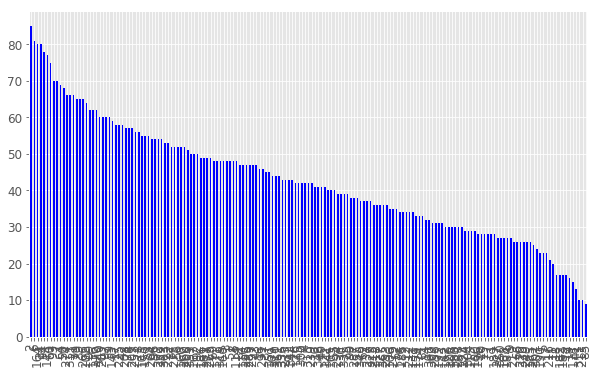

In [493]:
# bar chart of letter lengths in sentences
df_sent['letter_id'].value_counts().plot.bar(color='blue')

In [494]:
df_sent['words'] = df_sent.message_body.str.strip().str.split('[\W]+')
df_sent.head()

,letter_id,message_body,words
0,1,Miss O Ryan says I may come home Wednesday and...,"[Miss, O, Ryan, says, I, may, come, home, Wedn..."
0,1,"Pretty good, don't you think so? Haven't seen...","[Pretty, good, don, t, you, think, so, Haven, ..."
0,1,Haven't had any mail except a letter from the...,"[Haven, t, had, any, mail, except, a, letter, ..."
0,1,Suppose Helen won't be through until 6,"[Suppose, Helen, won, t, be, through, until, 6]"
0,1,"I think that maybe I can get through by then,...","[I, think, that, maybe, I, can, get, through, ..."


In [495]:
rows = list()
for row in df_sent[['letter_id', 'words']].iterrows():
    r = row[1]
    for word in r.words:
        rows.append((r.letter_id, word))

words = pd.DataFrame(rows, columns=['letter_id', 'word'])
words.head(20)

,letter_id,word
0,1,Miss
1,1,O
2,1,Ryan
3,1,says
4,1,I
5,1,may
6,1,come
7,1,home
8,1,Wednesday
9,1,and


In [496]:
words.shape

(152573, 2)

In [497]:
# remove lines with length 0 (empty lines)
words = words[words.word.str.len() > 0]
words.head()

,letter_id,word
0,1,Miss
1,1,O
2,1,Ryan
3,1,says
4,1,I


In [498]:
words.shape # now fewer rows

(151929, 2)

In [499]:
# make words lowercase
words['word'] = words.word.str.lower()
words.head()

,letter_id,word
0,1,miss
1,1,o
2,1,ryan
3,1,says
4,1,i


In [500]:
# count of each word per book
counts = words.groupby('letter_id')\
    .word.value_counts()\
    .to_frame()\
    .rename(columns={'word':'n_w'})
counts.head()

n_w
letter_id word     
1         the    11
          and     8
          i       7
          of      7
          a       6

In [501]:
# top n words per letter
def pretty_plot_top_n(series, top_n=5, index_level=0):
    r = series\
    .groupby(level=index_level)\
    .nlargest(top_n)\
    .reset_index(level=index_level, drop=True)
#     r.plot.bar()
    return r.to_frame()


pretty_plot_top_n(counts['n_w'])

n_w
letter_id word     
1         the    11
          and     8
          i       7
          of      7
          a       6
2         i     152
          and    83
          that   68
          to     62
          t      55
3         and    34
          the    33
          i      27
          to     24
          a      16
4         and    38
          to     31
          i      28
          the    27
          it     18
5         and    38
          the    30
          i      19
          a      13
          to     13
6         and    99
          the    65
          i      61
          to     54
          a      32
...             ...
351       and    39
          a      31
          the    31
          to     28
          it     22
353       and    52
          the    35
          to     29
          a      28
          i      23
359       to     31
          and    29
          it     24
          the    24
          he     21
361       and    39
          to     27
          the    24
          in     18
          i      16
363       and    46
          to     41
          the    40
          he     35
          a      30
365       and    40
          a      27
          to     20
          she    18
          the    17

[855 rows x 1 columns]

In [502]:
# get counts for each letter
word_sum = counts.groupby(level=0)\
    .sum()\
    .rename(columns={'n_w': 'n_d'})
word_sum

,n_d
letter_id,
1,307
2,2176
3,805
4,895
5,650
6,1908
7,1272
8,1260
9,530


In [503]:
# join on letter id to get sum of word per letter
tf = counts.join(word_sum)
tf['tf'] = tf.n_w/tf.n_d
tf.head()

n_w  n_d        tf
letter_id word                    
1         the    11  307  0.035831
          and     8  307  0.026059
          i       7  307  0.022801
          of      7  307  0.022801
          a       6  307  0.019544

In [504]:
# mostly stop words so far
pretty_plot_top_n(tf['tf'])

tf
letter_id word          
1         the   0.035831
          and   0.026059
          i     0.022801
          of    0.022801
          a     0.019544
2         i     0.069853
          and   0.038143
          that  0.031250
          to    0.028493
          t     0.025276
3         and   0.042236
          the   0.040994
          i     0.033540
          to    0.029814
          a     0.019876
4         and   0.042458
          to    0.034637
          i     0.031285
          the   0.030168
          it    0.020112
5         and   0.058462
          the   0.046154
          i     0.029231
          a     0.020000
          to    0.020000
6         and   0.051887
          the   0.034067
          i     0.031971
          to    0.028302
          a     0.016771
...                  ...
351       and   0.038614
          a     0.030693
          the   0.030693
          to    0.027723
          it    0.021782
353       and   0.049761
          the   0.033493
          to    0.027751
          a     0.026794
          i     0.022010
359       to    0.032874
          and   0.030753
          it    0.025451
          the   0.025451
          he    0.022269
361       and   0.050258
          to    0.034794
          the   0.030928
          in    0.023196
          i     0.020619
363       and   0.038365
          to    0.034195
          the   0.033361
          he    0.029191
          a     0.025021
365       and   0.048019
          a     0.032413
          to    0.024010
          she   0.021609
          the   0.020408

[855 rows x 1 columns]

In [505]:
# get number of letters
c_d = words.letter_id.nunique()
c_d

171

In [506]:
# number of unique books every term appeared in
idf = words.groupby('word')\
    .letter_id\
    .nunique()\
    .to_frame()\
    .rename(columns={'letter_id':'i_d'})\
    .sort_values('i_d')
idf.head()

,i_d
word,
ω,1
forke,1
regional,1
regards,1
regardless,1


In [507]:
# calculate idf as new column
idf['idf'] = np.log(c_d/idf.i_d.values)
idf.head()

,i_d,idf
word,,
ω,1,5.141664
forke,1,5.141664
regional,1,5.141664
regards,1,5.141664
regardless,1,5.141664


In [508]:
# get final dataframe by joining tf and idf
tf_idf = tf.join(idf)
tf_idf.head()

n_w  n_d        tf  i_d       idf
letter_id word                                   
1         the    11  307  0.035831  171  0.000000
          and     8  307  0.026059  170  0.005865
          i       7  307  0.022801  170  0.005865
          of      7  307  0.022801  170  0.005865
          a       6  307  0.019544  171  0.000000

In [509]:
# calculate tf-idf statistic
tf_idf['tf_idf'] = tf_idf.tf * tf_idf.idf
tf_idf.head()

n_w  n_d        tf  i_d       idf    tf_idf
letter_id word                                             
1         the    11  307  0.035831  171  0.000000  0.000000
          and     8  307  0.026059  170  0.005865  0.000153
          i       7  307  0.022801  170  0.005865  0.000134
          of      7  307  0.022801  170  0.005865  0.000134
          a       6  307  0.019544  171  0.000000  0.000000

In [510]:
pretty_plot_top_n(tf_idf['tf_idf'])

tf_idf
letter_id word                 
1         98           0.033496
          bailey       0.033496
          stenson      0.033496
          nursing      0.023011
          pain         0.019949
2         loved        0.014609
          engagement   0.014310
          love         0.010605
          fay          0.008656
          duane        0.008177
3         ribbon       0.035157
          sib          0.016004
          campaign     0.012774
          excuses      0.012774
          sugar        0.011910
4         honey        0.012588
          miller       0.011490
          apartment    0.010317
          court        0.010264
          kocian       0.009941
5         cotton       0.036076
          raw          0.018660
          seeds        0.018660
          hayrack      0.015821
          soooo        0.014579
6         sooooo       0.009259
          mrs          0.007760
          johnson      0.007440
          el           0.005554
          paso         0.005554
...                         ...
351       claremont    0.013213
          personnel    0.011155
          diego        0.009492
          colonial     0.008809
          escondido    0.008809
353       utility      0.012771
          beverly      0.009841
          lanes        0.009841
          job          0.009566
          stove        0.009174
359       mention      0.013556
          offer        0.010167
          tax          0.009435
          upset        0.008575
          cause        0.007965
361       sealing      0.026503
          dental       0.013656
          950          0.013252
          mins         0.013252
          800          0.010420
363       procedures   0.012865
          graduate     0.011131
          scholarship  0.011131
          walker       0.011131
          quarter      0.010116
365       progress     0.019182
          walker       0.016021
          sauce        0.012345
          sauerkraut   0.012345
          giggles      0.009707

[855 rows x 1 columns]

# Changing Pronouns

https://github.com/huggingface/neuralcoref  
https://spacy.io/usage/models

In [511]:
# ! pip install -U spacy

In [512]:
# # run once
# import spacy
# import en_core_web_lg
# from neuralcoref import Coref

# spacy = en_core_web_lg.load()
# coref = Coref(nlp=spacy)

In [513]:
# def replace_pronouns(text):
#     coref.one_shot_coref(text)
#     return coref.get_resolved_utterances()[0]

In [514]:
# # dataframe for pronouns
# df_pron = df[['letter_id','message_body']].copy()
# df_pron.head()

In [515]:
# python -m spacy download en_core_web_sm
# >>> import spacy
# >>> nlp = spacy.load('en_core_web_sm')

In [516]:
# df_pron['message_body_pronouns'] = df_pron['message_body'].apply(lambda x: replace_pronouns(x))
# df_pron.head()

In [517]:
# replace_pronouns('Sam went to the store. He is happy.')

# Salutations and Closings

## Salutation n-grams

In [518]:
df.columns

Index(['letter_id', 'input_id', 'letter_date', 'year', 'transcribed',
       'transcribed_by', 'needs_formatting', 'sender', 'sender_loc',
       'sender_loc_raw', 'sender_latitude', 'sender_longitude', 'recipient',
       'recipient_loc', 'rec_latitude', 'rec_longitude', 'envelope', 'partial',
       'postcard', 'postage', 'words', 'message_full', 'message_salutation',
       'message_body', 'message_closing', 'url', 'polarity', 'subjectivity'],
      dtype='object')

**Unigrams**

In [519]:
salutations = df.message_salutation.str.lower()
salutations = [str(sal) for sal in salutations] # string because numbers came thru as floats

stop = stopwords.words('english')
stop += ['.', ',', '(', ')', "'", '"','’','”','“']
stop = set(stop)

counter = Counter()

n = 1

for sal in salutations:
    sal_words = TextBlob(sal).words
    sal_words = [w for w in sal_words if w not in stop]
    results = ngrams(sal_words, n)
    counter += Counter(results)
    
for phrase, count in counter.most_common(40):
    print('%20s %i' % (" ".join(phrase), count))

                dear 77
                 mom 72
                good 68
             morning 62
               daddy 35
                 pop 23
             dearest 21
               folks 18
              mother 13
                mine 8
              mither 5
           greetings 4
           afternoon 4
                fine 4
             kidlets 3
               happy 3
                 etc 2
               means 2
                 fay 2
               hello 2
                 sal 2
                mugs 2
              dreges 2
                   n 2
               howdy 2
              mudder 2
              fodder 2
                mama 2
              easter 2
              father 2
             frances 1
             fritzie 1
              family 1
             grandma 1
            granddad 1
              auntie 1
              uncles 1
                  hi 1
                miss 1
               uncle 1


**Bigrams**

In [520]:
# salutations = df.message_salutation.str.lower()
# salutations = [str(sal) for sal in salutations] # string because numbers came thru as floats

counter = Counter()

n = 2

for sal in salutations:
    sal_words = TextBlob(sal).words
    sal_words = [w for w in sal_words if w not in stop]
    results = ngrams(sal_words, n)
    counter += Counter(results)
    
for phrase, count in counter.most_common(40):
    print('%20s %i' % (" ".join(phrase), count))

        good morning 62
            dear mom 50
           mom daddy 31
             mom pop 19
         dearest mom 10
       dearest folks 10
      morning mother 9
         morning mom 8
          dear folks 7
         mother mine 6
      good afternoon 4
      morning mither 4
         pop kidlets 3
            dear pop 3
          dear daddy 3
        morning dear 3
         dear mother 3
             pop etc 2
           etc means 2
            sal mugs 2
           daddy mom 2
        morning fine 2
        morning good 2
        happy easter 2
       mother father 2
           good good 2
       means frances 1
        dear fritzie 1
          pop family 1
        dear grandma 1
    grandma granddad 1
     granddad auntie 1
       auntie uncles 1
             hi miss 1
            miss fay 1
         means uncle 1
           uncle leo 1
afternoon grandfather 1
     grandfather fay 1
 greetings everybody 1


**Trigrams**

In [521]:
# salutations = df.message_salutation.str.lower()
# salutations = [str(sal) for sal in salutations] # string because numbers came thru as floats

counter = Counter()

n = 3

for sal in salutations:
    sal_words = TextBlob(sal).words
    sal_words = [w for w in sal_words if w not in stop]
    results = ngrams(sal_words, n)
    counter += Counter(results)
    
for phrase, count in counter.most_common(40):
    print('%20s %i' % (" ".join(phrase), count))

      dear mom daddy 29
        dear mom pop 11
 good morning mother 9
     dearest mom pop 8
    good morning mom 8
 morning mother mine 6
 good morning mither 4
     mom pop kidlets 3
   good morning dear 3
 morning dear mother 3
         mom pop etc 2
       pop etc means 2
   dearest mom daddy 2
      dear daddy mom 2
   good morning fine 2
   good morning good 2
morning good morning 2
  dear mother father 2
   good good morning 2
   etc means frances 1
      mom pop family 1
dear grandma granddad 1
grandma granddad auntie 1
granddad auntie uncles 1
         hi miss fay 1
     etc means uncle 1
     means uncle leo 1
good afternoon grandfather 1
afternoon grandfather fay 1
        mom pop kids 1
  good morning mater 1
 morning mater pater 1
good afternoon darling 1
        dear pop sal 1
        pop sal mugs 1
    dear drege folks 1
  good morning daddy 1
      happy new year 1
       mom daddy sal 1
      daddy sal mugs 1


**4-Grams**

In [522]:
# salutations = df.message_salutation.str.lower()
# salutations = [str(sal) for sal in salutations] # string because numbers came thru as floats

counter = Counter()

n = 4

for sal in salutations:
    sal_words = TextBlob(sal).words
    sal_words = [w for w in sal_words if w not in stop]
    results = ngrams(sal_words, n)
    counter += Counter(results)
    
for phrase, count in counter.most_common(50):
    print('%20s %i' % (" ".join(phrase), count))

good morning mother mine 6
dearest mom pop kidlets 3
good morning dear mother 3
   mom pop etc means 2
good morning good morning 2
morning dear mother father 2
    dear mom pop etc 1
pop etc means frances 1
dearest mom pop family 1
dear grandma granddad auntie 1
grandma granddad auntie uncles 1
 dearest mom pop etc 1
 pop etc means uncle 1
 etc means uncle leo 1
good afternoon grandfather fay 1
dearest mom pop kids 1
good morning mater pater 1
   dear pop sal mugs 1
  dear mom daddy sal 1
  mom daddy sal mugs 1
daddy sal mugs dreges 1
sal mugs dreges mongers 1
mugs dreges mongers f 1
dreges mongers f fays 1
dear patty pistrissa le 1
patty pistrissa le roy 1
pistrissa le roy little 1
le roy little female 1
roy little female cherubs 1
dear wabbits elephants e'er 1
wabbits elephants e'er case 1
elephants e'er case may 1
    e'er case may ha 1
      dear pop n mom 1
      dear mom n pop 1
dear parents laziest woman 1
parents laziest woman johnson 1
laziest woman johnson air 1
woman johnson

**5-Grams**

In [523]:
# salutations = df.message_salutation.str.lower()
# salutations = [str(sal) for sal in salutations] # string because numbers came thru as floats

counter = Counter()

n = 5

for sal in salutations:
    sal_words = TextBlob(sal).words
    sal_words = [w for w in sal_words if w not in stop]
    results = ngrams(sal_words, n)
    counter += Counter(results)
    
for phrase, count in counter.most_common(50):
    print('%20s %i' % (" ".join(phrase), count))

good morning dear mother father 2
dear mom pop etc means 1
mom pop etc means frances 1
dear grandma granddad auntie uncles 1
dearest mom pop etc means 1
mom pop etc means uncle 1
pop etc means uncle leo 1
dear mom daddy sal mugs 1
mom daddy sal mugs dreges 1
daddy sal mugs dreges mongers 1
sal mugs dreges mongers f 1
mugs dreges mongers f fays 1
dear patty pistrissa le roy 1
patty pistrissa le roy little 1
pistrissa le roy little female 1
le roy little female cherubs 1
dear wabbits elephants e'er case 1
wabbits elephants e'er case may 1
elephants e'er case may ha 1
dear parents laziest woman johnson 1
parents laziest woman johnson air 1
laziest woman johnson air force 1
woman johnson air force base 1
good morning fine fader mader 1
howdy mine fine papa mama 1
good good morning mother mine 1
good morning mother mine happy 1
morning mother mine happy easter 1


## Closing n-grams

**Unigrams**

In [524]:
closings = df.message_closing.str.lower()
closings = [str(clo) for clo in closings] # string because numbers came thru as floats

stop = stopwords.words('english')
stop += ['.', ',', '(', ')', "'", '"','’','”','“']
stop = set(stop)

counter = Counter()

n = 1

for clo in closings:
    clo_words = TextBlob(clo).words
    clo_words = [w for w in clo_words if w not in stop]
    results = ngrams(clo_words, n)
    counter += Counter(results)
    
for phrase, count in counter.most_common(100):
    print('%20s %i' % (" ".join(phrase), count))

                love 168
               betty 146
                  us 71
                lots 39
                mutt 34
                much 30
                 liz 16
              family 13
               karen 9
           toodle-oo 9
                kids 9
                time 6
                 ann 6
                next 4
             joneses 4
                  's 4
            'lizbeth 4
                till 3
                   6 3
           menagerie 3
              rodney 3
             richard 3
               jones 3
            chilluns 3
            children 3
                   n 3
              lizzie 2
                boys 2
              pounds 2
                   4 2
              ounces 2
               haste 2
              little 2
            leeshbit 2
                mark 2
                 got 2
                  ta 2
               chief 2
               think 2
               hurry 2
                soon 2
                doug 2
                tina 2
 

**Bigrams**

In [525]:
# closings = df.message_closing.str.lower()
# closings = [str(clo) for clo in closings] # string because numbers came thru as floats

counter = Counter()

n = 2

for clo in closings:
    clo_words = TextBlob(clo).words
    clo_words = [w for w in clo_words if w not in stop]
    results = ngrams(clo_words, n)
    counter += Counter(results)
    
for phrase, count in counter.most_common(40):
    print('%20s %i' % (" ".join(phrase), count))

          love betty 70
             love us 69
            us betty 56
           lots love 33
          betty mutt 32
           much love 20
           much much 10
              us liz 8
          mutt karen 7
            love liz 7
        betty family 6
         mutt family 6
      toodle-oo love 5
           mutt kids 5
           time love 4
       joneses betty 4
       love 'lizbeth 4
        'lizbeth ann 4
           till next 3
           next time 3
          kids betty 3
        love joneses 3
         love lizzie 2
      mutt menagerie 2
        karen rodney 2
            6 pounds 2
         family love 2
       love leeshbit 2
      rodney richard 2
        richard mark 2
              got ta 2
   children children 2
     betty toodle-oo 2
         betty think 2
         hurry betty 2
           soon love 2
           doug tina 2
             lots 'n 2
             'n lots 2
              lots n 2


**Trigrams**

In [526]:
# closings = df.message_closing.str.lower()
# closings = [str(clo) for clo in closings] # string because numbers came thru as floats

counter = Counter()

n = 3

for clo in closings:
    clo_words = TextBlob(clo).words
    clo_words = [w for w in clo_words if w not in stop]
    results = ngrams(clo_words, n)
    counter += Counter(results)
    
for phrase, count in counter.most_common(40):
    print('%20s %i' % (" ".join(phrase), count))

       love us betty 56
     lots love betty 18
     love betty mutt 14
        lots love us 13
       us betty mutt 11
     much love betty 11
      much much love 10
         love us liz 8
    betty mutt karen 7
        much love us 6
   betty mutt family 5
     betty mutt kids 5
   love betty family 4
   love 'lizbeth ann 4
      till next time 3
      next time love 3
     time love betty 3
  joneses betty mutt 3
  love joneses betty 3
betty mutt menagerie 2
   mutt karen rodney 2
     kids betty mutt 2
     us betty family 2
 rodney richard mark 2
   toodle-oo love us 2
  much love 'lizbeth 2
     soon love betty 2
        lots 'n lots 2
        'n lots love 2
         lots n lots 2
      must scoot bed 1
     scoot bed soooo 1
      bed soooo lots 1
     soooo lots love 1
        lots love ca 1
         love ca n't 1
         ca n't send 1
    n't send anymore 1
  send anymore betty 1
        time love us 1


**4-Grams**

In [527]:
# closings = df.message_closing.str.lower()
# closings = [str(clo) for clo in closings] # string because numbers came thru as floats

counter = Counter()

n = 4

for clo in closings:
    clo_words = TextBlob(clo).words
    clo_words = [w for w in clo_words if w not in stop]
    results = ngrams(clo_words, n)
    counter += Counter(results)
    
for phrase, count in counter.most_common(40):
    print('%20s %i' % (" ".join(phrase), count))

  lots love us betty 12
  love us betty mutt 11
  much love us betty 6
lots love betty mutt 4
much much love betty 4
 till next time love 3
love betty mutt karen 3
love betty mutt family 3
  us betty mutt kids 3
   much much love us 3
next time love betty 2
time love betty mutt 2
joneses betty mutt karen 2
 us betty mutt karen 2
betty mutt karen rodney 2
love us betty family 2
love joneses betty mutt 2
much much love 'lizbeth 2
much love 'lizbeth ann 2
   lots 'n lots love 2
must scoot bed soooo 1
scoot bed soooo lots 1
 bed soooo lots love 1
  soooo lots love ca 1
    lots love ca n't 1
    love ca n't send 1
 ca n't send anymore 1
n't send anymore betty 1
   next time love us 1
  time love us betty 1
 love betty mutt one 1
betty mutt one golly 1
 love three us butty 1
 three us butty mutt 1
     us butty mutt 6 1
  butty mutt 6 pound 1
      mutt 6 pound 7 1
     6 pound 7 ounce 1
pound 7 ounce bundle 1
7 ounce bundle loveliness 1


**5-Grams**

In [528]:
# closings = df.message_closing.str.lower()
# closings = [str(clo) for clo in closings] # string because numbers came thru as floats

counter = Counter()

n = 5

for clo in closings:
    clo_words = TextBlob(clo).words
    clo_words = [w for w in clo_words if w not in stop]
    results = ngrams(clo_words, n)
    counter += Counter(results)
    
for phrase, count in counter.most_common(40):
    print('%20s %i' % (" ".join(phrase), count))

lots love us betty mutt 5
love us betty mutt kids 3
much much love us betty 3
till next time love betty 2
lots love betty mutt karen 2
love us betty mutt karen 2
much much love 'lizbeth ann 2
must scoot bed soooo lots 1
scoot bed soooo lots love 1
bed soooo lots love ca 1
soooo lots love ca n't 1
lots love ca n't send 1
love ca n't send anymore 1
ca n't send anymore betty 1
till next time love us 1
next time love us betty 1
time love us betty mutt 1
next time love betty mutt 1
time love betty mutt one 1
love betty mutt one golly 1
love three us butty mutt 1
three us butty mutt 6 1
us butty mutt 6 pound 1
butty mutt 6 pound 7 1
mutt 6 pound 7 ounce 1
6 pound 7 ounce bundle 1
pound 7 ounce bundle loveliness 1
7 ounce bundle loveliness karen 1
ounce bundle loveliness karen marie 1
love rebels south carolina joneses 1
rebels south carolina joneses betty 1
south carolina joneses betty mutt 1
carolina joneses betty mutt karen 1
us betty mutt karen rodney 1
betty mutt karen rodney leroy 1
mut

**6-Grams**

In [529]:
# closings = df.message_closing.str.lower()
# closings = [str(clo) for clo in closings] # string because numbers came thru as floats

counter = Counter()

n = 6

for clo in closings:
    clo_words = TextBlob(clo).words
    clo_words = [w for w in clo_words if w not in stop]
    results = ngrams(clo_words, n)
    counter += Counter(results)
    
for phrase, count in counter.most_common(40):
    print('%20s %i' % (" ".join(phrase), count))

must scoot bed soooo lots love 1
scoot bed soooo lots love ca 1
bed soooo lots love ca n't 1
soooo lots love ca n't send 1
lots love ca n't send anymore 1
love ca n't send anymore betty 1
till next time love us betty 1
next time love us betty mutt 1
till next time love betty mutt 1
next time love betty mutt one 1
time love betty mutt one golly 1
love three us butty mutt 6 1
three us butty mutt 6 pound 1
us butty mutt 6 pound 7 1
butty mutt 6 pound 7 ounce 1
mutt 6 pound 7 ounce bundle 1
6 pound 7 ounce bundle loveliness 1
pound 7 ounce bundle loveliness karen 1
7 ounce bundle loveliness karen marie 1
love rebels south carolina joneses betty 1
rebels south carolina joneses betty mutt 1
south carolina joneses betty mutt karen 1
lots love us betty mutt karen 1
love us betty mutt karen rodney 1
us betty mutt karen rodney leroy 1
betty mutt karen rodney leroy richard 1
mutt karen rodney leroy richard edward 1
love us betty mutt karen boys 1
us betty mutt karen boys 6 1
betty mutt karen boys

# Modeling NLP Relationships

## Doc2Vec

**Not a good fit.** Data too small, even when I used more epochs, increased steps in `infer_vector()`, and dropped alpha for `infer_vector()` to be tiny.

Guided example from https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/doc2vec-lee.ipynb  
Wet blanket from https://stackoverflow.com/questions/49631758/gensim-doc2vec-most-similar-method-not-working-as-expected

In [530]:
# import gensim
# import os
# import collections
# import smart_open
# import random

In [531]:
df.message_body

0      Miss O Ryan says I may come home Wednesday and...
1      Your letter came about an hour ago, Mom. The t...
2      Mom your super-duper letters came, so will ans...
3      My little man is writing to his folks, so I'll...
4      We got your super-duper letter yesterday, Mom,...
5      I'm lying on my tummy on the bed, so if you ca...
6      Mutt just brought your "manuscript" home, and ...
7      I really hit the jackpot yesterday!! Got a let...
8      Well, we dood it!!! Got the cutest little dark...
9      This is going to be a joint letter because I'd...
10     Tis gonna be a short note, but nevertheless we...
11     Well, here I am, late again!! Hope you had a h...
12     Gee, won't be long I can say that, will it, so...
13     Your letter about Uncle Bern got here day befo...
14     All is quiet on the Jones front, as yet!! Mutt...
15     Just finished my ironing so will take a few mi...
16     It's visiting hours and I don't got no company...
17     Mom came up to see me la

In [532]:
train_corpus = [gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(msg), [i]) for i, msg in enumerate(df.message_body.tolist())]
train_corpus[0]

TaggedDocument(words=['miss', 'ryan', 'says', 'may', 'come', 'home', 'wednesday', 'and', 'do', 'not', 'need', 'to', 'come', 'back', 'to', 'work', 'till', 'friday', 'noon', 'pretty', 'good', 'don', 'you', 'think', 'so', 'haven', 'seen', 'helen', 'today', 'but', 'mrs', 'selland', 'said', 'that', 'fam', 'and', 'helen', 'were', 'in', 'town', 'cuz', 'she', 'saw', 'you', 'haven', 'had', 'any', 'mail', 'except', 'letter', 'from', 'the', 'corporal', 'and', 'one', 'from', 'the', 'sailor', 'last', 'week', 'suppose', 'helen', 'won', 'be', 'through', 'until', 'think', 'that', 'maybe', 'can', 'get', 'through', 'by', 'then', 'too', 'got', 'all', 'my', 'test', 'papers', 'back', 'now', 'told', 'you', 'some', 'of', 'the', 'marks', 'before', 'think', 'but', 'in', 'case', 'you', 'like', 'to', 'know', 'them', 'all', 'here', 'goes', 'anatomy', 'kids', 'flunked', 'below', 'and', 'only', 'others', 'above', 'ethics', 'nursing', 'arts', 'medical', 'nursing', 'thelma', 'selling', 'had', 'her', 'appendix', 'remo

In [533]:
test_corpus = [gensim.utils.simple_preprocess(msg) for msg in df.message_body.tolist()]
print(test_corpus[0])

['miss', 'ryan', 'says', 'may', 'come', 'home', 'wednesday', 'and', 'do', 'not', 'need', 'to', 'come', 'back', 'to', 'work', 'till', 'friday', 'noon', 'pretty', 'good', 'don', 'you', 'think', 'so', 'haven', 'seen', 'helen', 'today', 'but', 'mrs', 'selland', 'said', 'that', 'fam', 'and', 'helen', 'were', 'in', 'town', 'cuz', 'she', 'saw', 'you', 'haven', 'had', 'any', 'mail', 'except', 'letter', 'from', 'the', 'corporal', 'and', 'one', 'from', 'the', 'sailor', 'last', 'week', 'suppose', 'helen', 'won', 'be', 'through', 'until', 'think', 'that', 'maybe', 'can', 'get', 'through', 'by', 'then', 'too', 'got', 'all', 'my', 'test', 'papers', 'back', 'now', 'told', 'you', 'some', 'of', 'the', 'marks', 'before', 'think', 'but', 'in', 'case', 'you', 'like', 'to', 'know', 'them', 'all', 'here', 'goes', 'anatomy', 'kids', 'flunked', 'below', 'and', 'only', 'others', 'above', 'ethics', 'nursing', 'arts', 'medical', 'nursing', 'thelma', 'selling', 'had', 'her', 'appendix', 'removed', 'this', 'mornin

In [534]:
# building model - play with parameters here
model = gensim.models.doc2vec.Doc2Vec(vector_size=10, epochs=500)

In [535]:
model.build_vocab(train_corpus)

In [536]:
ranks = []
second_ranks = []
for doc_id in range(len(train_corpus)):
    inferred_vector = model.infer_vector(train_corpus[doc_id].words, alpha=.00025, steps=500)
    sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)
    second_ranks.append(sims[1])

In [537]:
collections.Counter(ranks)

Counter({0: 1,
         1: 2,
         2: 1,
         3: 1,
         4: 1,
         8: 1,
         9: 2,
         10: 2,
         11: 2,
         12: 1,
         14: 3,
         16: 1,
         20: 1,
         21: 1,
         23: 1,
         25: 1,
         26: 1,
         27: 2,
         32: 1,
         33: 2,
         34: 1,
         36: 1,
         37: 2,
         40: 1,
         42: 1,
         45: 1,
         51: 2,
         52: 1,
         53: 2,
         54: 2,
         57: 1,
         58: 1,
         59: 3,
         60: 1,
         61: 2,
         62: 1,
         64: 2,
         65: 6,
         66: 1,
         69: 3,
         71: 2,
         72: 1,
         73: 2,
         74: 4,
         76: 1,
         77: 2,
         79: 1,
         80: 1,
         81: 1,
         82: 2,
         83: 1,
         86: 1,
         87: 2,
         89: 1,
         90: 1,
         91: 2,
         93: 3,
         94: 5,
         95: 1,
         97: 2,
         100: 2,
         104: 3,
         105:

In [538]:
# Pick a random document from the test corpus and infer a vector from the model
doc_id = random.randint(0, len(test_corpus) - 1)
inferred_vector = model.infer_vector(test_corpus[doc_id])
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))

# Compare and print the most/median/least similar documents from the train corpus
print('Test Document ({}): «{}»\n'.format(doc_id, ' '.join(test_corpus[doc_id])))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_corpus[sims[index][0]].words)))

Test Document (107): «dougie and are watching captain kangaroo so it is good time to talk to you minute time flies by so fast worked from to last night and am always slower getting started the next morning just work thursday and friday night and it is much better working these hours than the day shift not so much confusion am the only rn on after on rd south but have two aids with me there are patients which is handful since about are or over and several have fractured hips or legs and need special care to keep bedsores away like to take care of babies and older patients anyway so do enjoy it they called yesterday to see if would not work weekends every once in awhile but said mix do not want to give up my scouts and cannot do everything and do decent job so part time hospital work will have to be limited by the way daddy this is science month in cub scouts and since your outdoor thermometer is not real accurate will send you one that the scouts made last week this is real accurate and

## TF-IDF Vectorizer

In [539]:
# find cosine similarity across letters
vect = TfidfVectorizer(stop_words='english') # tested bigrams, trigrams, min_df=3 as well
tfidf = vect.fit_transform(df.message_body.tolist())
cosinesims = (tfidf * tfidf.T).A  # creates numpy array
simslist = list(cosinesims)  # convert to list so I can iterate
for i in range(len(simslist)):
    print(simslist[i].argsort()[:][-6:-1]) # returns df index of top 5 letters
    
# idea from https://stackoverflow.com/questions/8897593/similarity-between-two-text-documents

[75 27 61  5  6]
[ 54  56 101   5  53]
[36 53 12  3  5]
[28  7 88  5  4]
[90  7  5  6  3]
[ 7 88  1  6  3]
[53 98 90  7  5]
[15  6 10  9  8]
[ 6 28  9 27  7]
[ 75   8 100  35   7]
[93 44  5 36  7]
[10 58 47 75 96]
[139  90   5  75  13]
[ 36   5  12 121 125]
[ 53   7 119  21   9]
[103  53  16  27   7]
[22 67 15 21 90]
[ 21 133  70   8  16]
[102  53   3  67  19]
[135  53  36  34  18]
[36  1 22  5 47]
[58 68 28 36 47]
[ 57  56 114  24  29]
[ 58  36 104  32  65]
[89 87 22 29 41]
[ 19 116  91  36  24]
[16  1 53 75  5]
[58 15 75  7 28]
[ 3 30 47 68 27]
[47 67 40 22 24]
[29  7 99 75 28]
[87 75 35 36 86]
[125  53  23   5  65]
[40 84 75 21 31]
[36 67 45 47 35]
[ 63 100  73  34  46]
[47 58 86 75 37]
[52 40 75 59 36]
[105 114  90  70  69]
[55 90 47  7 54]
[83 54 29 69 75]
[53 81 71 29 24]
[ 7  5 54 36 58]
[46 60 96 55 44]
[ 47  55   5 125  43]
[100  90  73  35  34]
[ 74  73 100  47  35]
[75 67 36 34 68]
[56 47 54  5  1]
[34 68 85 78 53]
[15 73 32 19 53]
[69 59 36 75 66]
[  5  64 119   1  75]
[105

In [540]:
# make list with index of 5 most similar letters in increasing relevance
# ex: best rec for first item is 6, then 5, then 61...
top_5_indices = []
for i in range(len(simslist)):
    top_5_indices.append(list(simslist[i].argsort()[:][-6:-1]))
top_5_indices

[[75, 27, 61, 5, 6],
 [54, 56, 101, 5, 53],
 [36, 53, 12, 3, 5],
 [28, 7, 88, 5, 4],
 [90, 7, 5, 6, 3],
 [7, 88, 1, 6, 3],
 [53, 98, 90, 7, 5],
 [15, 6, 10, 9, 8],
 [6, 28, 9, 27, 7],
 [75, 8, 100, 35, 7],
 [93, 44, 5, 36, 7],
 [10, 58, 47, 75, 96],
 [139, 90, 5, 75, 13],
 [36, 5, 12, 121, 125],
 [53, 7, 119, 21, 9],
 [103, 53, 16, 27, 7],
 [22, 67, 15, 21, 90],
 [21, 133, 70, 8, 16],
 [102, 53, 3, 67, 19],
 [135, 53, 36, 34, 18],
 [36, 1, 22, 5, 47],
 [58, 68, 28, 36, 47],
 [57, 56, 114, 24, 29],
 [58, 36, 104, 32, 65],
 [89, 87, 22, 29, 41],
 [19, 116, 91, 36, 24],
 [16, 1, 53, 75, 5],
 [58, 15, 75, 7, 28],
 [3, 30, 47, 68, 27],
 [47, 67, 40, 22, 24],
 [29, 7, 99, 75, 28],
 [87, 75, 35, 36, 86],
 [125, 53, 23, 5, 65],
 [40, 84, 75, 21, 31],
 [36, 67, 45, 47, 35],
 [63, 100, 73, 34, 46],
 [47, 58, 86, 75, 37],
 [52, 40, 75, 59, 36],
 [105, 114, 90, 70, 69],
 [55, 90, 47, 7, 54],
 [83, 54, 29, 69, 75],
 [53, 81, 71, 29, 24],
 [7, 5, 54, 36, 58],
 [46, 60, 96, 55, 44],
 [47, 55, 5, 125,

In [541]:
df.tail(10)

,letter_id,input_id,letter_date,year,transcribed,transcribed_by,needs_formatting,sender,sender_loc,sender_loc_raw,...,postcard,postage,words,message_full,message_salutation,message_body,message_closing,url,polarity,subjectivity
161,344,1426,9/12/69,1969,1,M Turk (A1VYRD3HO2WDUN),1.0,Elizabeth Jones,"Klamath Falls, OR","Klamath Falls, OR",...,0,NaN,604.0,"Dear Mom, Welllllll, kids all gone again and m...","Dear Mom,","Welllllll, kids all gone again and me n' my sh...","Much love, Betty",https://static1.squarespace.com/static/5ad67c3...,0.170356,0.539175
162,346,1447,9/26/69,1969,1,M Turk (A3DZGDF9HCTAOB),1.0,Elizabeth Jones,"Klamath Falls, OR","Klamath Falls, OR",...,0,NaN,704.0,"Good morning, Mom! Well, as I wrote the date i...","Good morning, Mom!","Well, as I wrote the date in the corner, it da...","Much, much love, Betty",https://static1.squarespace.com/static/5ad67c3...,0.234116,0.528757
163,348,1441,10/9/69,1969,1,M Turk (A3DZGDF9HCTAOB),1.0,Elizabeth Jones,"Klamath Falls, OR","Klamath Falls, OR",...,0,NaN,998.0,"Good morning, mom! Jack LaLanne is exercising,...","Good morning, mom!","Jack LaLanne is exercising, and I am watching ...","Lots of love, Betty, Mutt, Doug and Tina",https://static1.squarespace.com/static/5ad67c3...,0.198045,0.462600
164,350,1438,10/16/69,1969,1,M Turk (A3S6UWT0JNCJFE),1.0,Elizabeth Jones,"Klamath Falls, OR","Klamath Falls, OR",...,0,NaN,781.0,"Good Morning, Mom, I'm washed and curled and u...","Good Morning, Mom,","I'm washed and curled and under the dryer, so ...","Much love, Betty",https://static1.squarespace.com/static/5ad67c3...,0.185709,0.533240
165,351,1445,10/24/69,1969,1,M Turk (A3S6UWT0JNCJFE),1.0,Elizabeth Jones,"Klamath Falls, OR","Klamath Falls, OR",...,0,NaN,975.0,"And a Good, Good Morning to you, Mama!! We hav...","And a Good, Good Morning to you, Mama!!",We have a house!!! Karen called last night abo...,"Lots n lots o' love, Betty",https://static1.squarespace.com/static/5ad67c3...,0.096302,0.495232
166,353,1433,11/5/69,1969,1,M Turk (A3S6UWT0JNCJFE),1.0,Elizabeth Jones,"San Diego, CA","San Diego, CA",...,0,NaN,996.0,"Good Morning, Mom, Here I sit, on Doug's rolle...","Good Morning, Mom,","Here I sit, on Doug's rolled up sleeping bag, ...","Much love, Betty",https://static1.squarespace.com/static/5ad67c3...,0.152247,0.532019
167,359,1456,2/17/70,1970,1,M Turk (A3R79CYQ817AV3),1.0,Elizabeth Jones,"San Diego, CA","San Diego, CA",...,0,NaN,904.0,"Good Morning, Mither, How are things with you?...","Good Morning, Mither, How are things with you?","Don't hear from anyone up that away, so I do w...",Love ya lots! Betty.,https://static1.squarespace.com/static/5ad67c3...,0.217418,0.580098
168,361,1457,2/25/70,1970,1,M Turk (A3CA5SLHQTNDHU),1.0,Elizabeth Jones,"San Diego, CA","San Diego, CA",...,0,NaN,746.0,"Good Morning, Mother, Should be scrubbing my k...","Good Morning, Mother,",Should be scrubbing my kitchen floor and doing...,"Love, Betty",https://static1.squarespace.com/static/5ad67c3...,0.130538,0.394127
169,363,1454,5/6/70,1970,1,M Turk (A3CA5SLHQTNDHU),1.0,Elizabeth Jones,"San Diego, CA","San Diego, CA",...,0,NaN,1145.0,"Good Morning, Mother O' Mine! Margie called me...","Good Morning, Mother O' Mine!",Margie called me Saturday night and I'm sooooo...,"Lots n' lots of luck n' love, Betty",https://static1.squarespace.com/static/5ad67c3...,0.111635,0.435120
170,365,1460,6/8/70,1970,1,M Turk (A3DZGDF9HCTAOB),1.0,Elizabeth Jones,"San Diego, CA","San Diego, CA",...,0,NaN,842.0,"Greetings me fine mither, I am all beautiful a...","Greetings me fine mither,",I am all beautiful again (Thanks to Krohn Drug...,"Love, ""Leeshbit"" as (Eliz. Mitzel used to say ...",https://static1.squarespace.com/static/5ad67c3...,0.151089,0.474681


In [542]:
rec_indx_columns = ['rec5', 'rec4', 'rec3', 'rec2', 'rec1'] # note that these are indices, not letter ids
df_letterrecs = pd.DataFrame(top_5_indices, columns=rec_indx_columns)
df_letterrecs.head()

,rec5,rec4,rec3,rec2,rec1
0,75,27,61,5,6
1,54,56,101,5,53
2,36,53,12,3,5
3,28,7,88,5,4
4,90,7,5,6,3


In [543]:
df_letterrecs.describe()

,rec5,rec4,rec3,rec2,rec1
count,171.000000,171.000000,171.000000,171.000000,171.000000
mean,83.374269,82.994152,83.853801,82.163743,83.099415
std,47.543667,42.601643,44.549202,47.576033,49.431671
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,47.000000,55.000000,47.000000,36.000000,43.500000
50%,87.000000,86.000000,90.000000,87.000000,83.000000
75%,121.000000,114.000000,117.000000,122.500000,127.000000
max,169.000000,167.000000,169.000000,169.000000,170.000000


In [544]:
df_letterrecs.index = df.index # synchronize indices so they concatenate nicely, since order is same
df = pd.concat([df, df_letterrecs], axis=1)

df.tail()

,letter_id,input_id,letter_date,year,transcribed,transcribed_by,needs_formatting,sender,sender_loc,sender_loc_raw,...,message_body,message_closing,url,polarity,subjectivity,rec5,rec4,rec3,rec2,rec1
166,353,1433,11/5/69,1969,1,M Turk (A3S6UWT0JNCJFE),1.0,Elizabeth Jones,"San Diego, CA","San Diego, CA",...,"Here I sit, on Doug's rolled up sleeping bag, ...","Much love, Betty",https://static1.squarespace.com/static/5ad67c3...,0.152247,0.532019,135,132,36,151,165
167,359,1456,2/17/70,1970,1,M Turk (A3R79CYQ817AV3),1.0,Elizabeth Jones,"San Diego, CA","San Diego, CA",...,"Don't hear from anyone up that away, so I do w...",Love ya lots! Betty.,https://static1.squarespace.com/static/5ad67c3...,0.217418,0.580098,132,141,142,162,154
168,361,1457,2/25/70,1970,1,M Turk (A3CA5SLHQTNDHU),1.0,Elizabeth Jones,"San Diego, CA","San Diego, CA",...,Should be scrubbing my kitchen floor and doing...,"Love, Betty",https://static1.squarespace.com/static/5ad67c3...,0.130538,0.394127,87,36,167,154,132
169,363,1454,5/6/70,1970,1,M Turk (A3CA5SLHQTNDHU),1.0,Elizabeth Jones,"San Diego, CA","San Diego, CA",...,Margie called me Saturday night and I'm sooooo...,"Lots n' lots of luck n' love, Betty",https://static1.squarespace.com/static/5ad67c3...,0.111635,0.435120,105,139,142,69,170
170,365,1460,6/8/70,1970,1,M Turk (A3DZGDF9HCTAOB),1.0,Elizabeth Jones,"San Diego, CA","San Diego, CA",...,I am all beautiful again (Thanks to Krohn Drug...,"Love, ""Leeshbit"" as (Eliz. Mitzel used to say ...",https://static1.squarespace.com/static/5ad67c3...,0.151089,0.474681,5,55,120,98,169


In [545]:
dict_indextoletterid = df['letter_id'].to_dict()
dict_indextoletterid

{0: 1,
 1: 2,
 2: 3,
 3: 4,
 4: 5,
 5: 6,
 6: 7,
 7: 8,
 8: 9,
 9: 10,
 10: 11,
 11: 12,
 12: 13,
 13: 14,
 14: 15,
 15: 16,
 16: 17,
 17: 18,
 18: 19,
 19: 20,
 20: 24,
 21: 27,
 22: 31,
 23: 37,
 24: 39,
 25: 40,
 26: 41,
 27: 42,
 28: 43,
 29: 50,
 30: 51,
 31: 52,
 32: 53,
 33: 55,
 34: 56,
 35: 59,
 36: 60,
 37: 62,
 38: 64,
 39: 66,
 40: 69,
 41: 72,
 42: 74,
 43: 75,
 44: 76,
 45: 77,
 46: 78,
 47: 79,
 48: 81,
 49: 82,
 50: 85,
 51: 87,
 52: 90,
 53: 92,
 54: 93,
 55: 94,
 56: 96,
 57: 97,
 58: 99,
 59: 100,
 60: 102,
 61: 103,
 62: 106,
 63: 109,
 64: 110,
 65: 114,
 66: 115,
 67: 116,
 68: 122,
 69: 126,
 70: 127,
 71: 130,
 72: 132,
 73: 143,
 74: 144,
 75: 145,
 76: 150,
 77: 155,
 78: 159,
 79: 160,
 80: 162,
 81: 164,
 82: 165,
 83: 166,
 84: 167,
 85: 171,
 86: 174,
 87: 176,
 88: 178,
 89: 180,
 90: 181,
 91: 182,
 92: 183,
 93: 184,
 94: 185,
 95: 186,
 96: 188,
 97: 189,
 98: 190,
 99: 191,
 100: 192,
 101: 196,
 102: 197,
 103: 203,
 104: 206,
 105: 208,
 106: 209,
 

In [546]:
# use dictionary to convert indices to letter_id
df['rec1'] = df['rec1'].apply(lambda x: dict_indextoletterid[x])
df['rec2'] = df['rec2'].apply(lambda x: dict_indextoletterid[x])
df['rec3'] = df['rec3'].apply(lambda x: dict_indextoletterid[x])
df['rec4'] = df['rec4'].apply(lambda x: dict_indextoletterid[x])
df['rec5'] = df['rec5'].apply(lambda x: dict_indextoletterid[x])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a20ffe550>]],
      dtype=object)

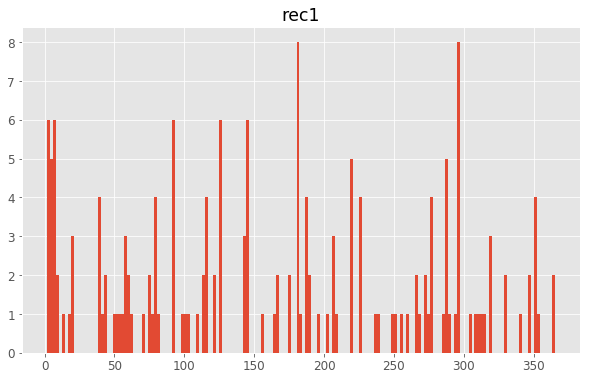

In [547]:
df.hist(column='rec1', bins=171)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a20a03b70>]],
      dtype=object)

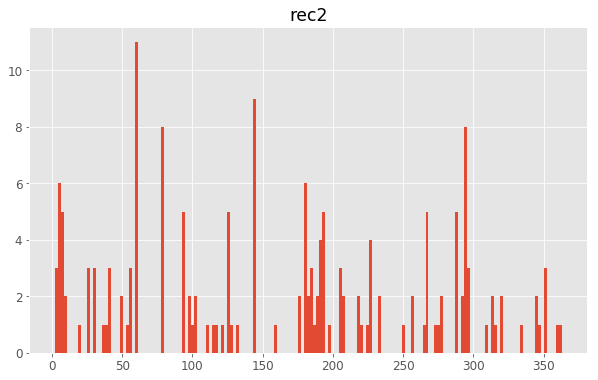

In [548]:
df.hist(column='rec2', bins=171)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a19d1f2e8>]],
      dtype=object)

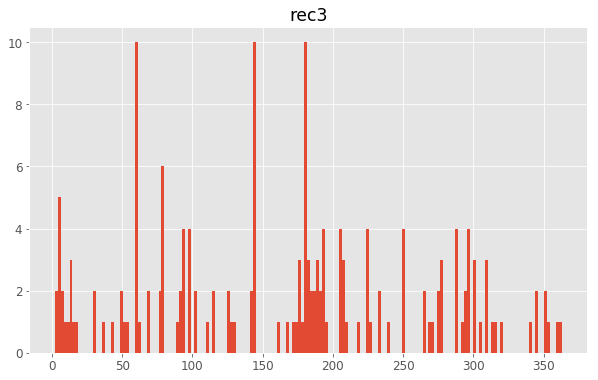

In [549]:
df.hist(column='rec3', bins=171)

## LDA

In [550]:
# add to stop words list
stop3 = list(stop2)
stop3 += ['00','30', '10', 'really', 'till', 'would', 'äúwarrant']
stop3 = set(stop3)

In [551]:
stop3

{'"',
 "'",
 "'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 '(',
 ')',
 ',',
 '.',
 '00',
 '10',
 '30',
 'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 "n't",
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',

**First Method with 20 Topics**

In [552]:
# messages = df.message_body.str.lower() # from earlier
vect = CountVectorizer(stop_words=stop3, max_df=.7) # ngram_range=(1,2),
X = vect.fit_transform(messages)

In [553]:
lda = LatentDirichletAllocation(n_components=20, learning_method='batch', max_iter=25, random_state=0)

In [554]:
document_topics = lda.fit_transform(X)

In [555]:
print('lda.components_.shape: {}'.format(lda.components_.shape))

lda.components_.shape: (20, 8174)


In [556]:
# sorting features for each topic; have to specify for descending
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
feature_names = np.array(vect.get_feature_names())

In [557]:
# print out the 20 topics
mglearn.tools.print_topics(topics=range(20), feature_names=feature_names, sorting=sorting, topics_per_chunk=5, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
tell          school        work          work          uncle         
figure        next          house         letter        doug          
house         better        dougie        boys          boys          
work          big           next          though        mark          
enjoyed       first         mark          take          school        
etc           week          school        cake          two           
christmas     ha            come          doug          john          
could         work          around        make          next          
weekend       way           days          made          first         
next          take          boys          year          come          


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      
new 

**Second Method with 100 Topics**

In [558]:
lda100 = LatentDirichletAllocation(n_components=100, learning_method='batch', max_iter=25, random_state=0)
document_topics100 = lda100.fit_transform(X)

In [559]:
# sorting features for each topics; have to specify for descending
sorting = np.argsort(lda100.components_, axis=1)[:, ::-1]
feature_names = np.array(vect.get_feature_names())

In [560]:
# print out the 100 topics
mglearn.tools.print_topics(topics=range(100), feature_names=feature_names, sorting=sorting, topics_per_chunk=5, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
äútalked      cake          week          doug          accordion     
farmers       work          house         degrees       rich          
family        bunch         room          took          mark          
famous        huckleberry   next          letter        fail          
fan           dougie        maybe         california    doug          
fancy         latest        dougie        year          pass          
fans          hound         nice          boys          year          
far           next          christmas     anyway        next          
farce         accurate      come          pm            week          
fare          move          new           temperature   even          


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      
mark

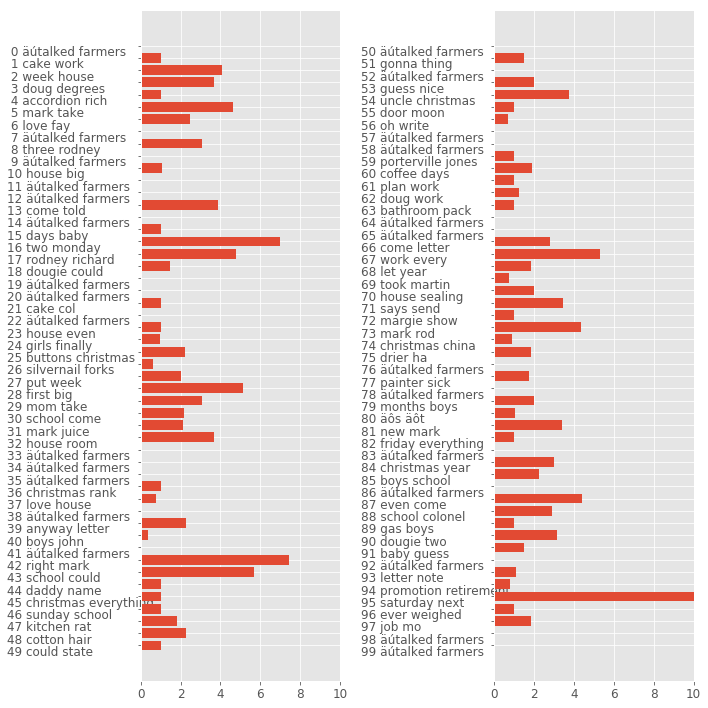

In [561]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
topic_names = ['{:>2} '.format(i) + ' '.join(words) for i, words in enumerate(feature_names[sorting[:, :2]])]

# two column bar chart
for col in [0, 1]:
    start = col * 50
    end = (col + 1) * 50
    ax[col].barh(np.arange(50), np.sum(document_topics100, axis=0)[start:end])
    ax[col].set_yticks(np.arange(50))
    ax[col].set_yticklabels(topic_names[start:end], ha='left', va='top')
    ax[col].invert_yaxis()
    ax[col].set_xlim(0, 10)
    yax = ax[col].get_yaxis()
    yax.set_tick_params(pad=130)
plt.tight_layout()

## Guided LDA